Epoch 1/1
45691/45691 [==============================] - 8s 174us/step - loss: 0.0482


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
delta_label  0.0002626337790812195 < tol  0.001
Reached tolerance threshold. Stopping training.


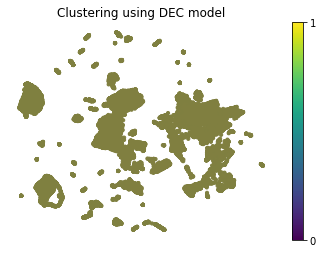

'\n\n#y_pred_kmeans.shape\nx_embedded = TSNE(n_components=2).fit_transform(encoder.predict(x))\n\n#y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))\n#vis_x = x_embedded[:, 0]\n#vis_y = x_embedded[:, 1]\n\n#vis_xx = y_embedded[:, 0]\n#vis_yy = y_embedded[:, 1]\n#plot1 = plt.figure(4)\n#plt.scatter(visx, visy, c=y_pred_kmeans)\n#plt.colorbar(ticks=range(256))\n#plt.title(\'Clustering using K-means model\')\n#plt.xlabel(\'PCA1\')\n#plt.ylabel(\'PCA2\')\n#plt.show()\n\nplot1 = plt.figure(5)\nplt.scatter(vis_x, vis_y, c=y_pred_kmeans, marker=".", markersize=10)\nplt.colorbar(ticks=range(256))\n#plt.clim(-0.5, 9.5)\nplt.title(\'Clustering using K-means model\')\nplt.xlabel(\'tSNE1\')\nplt.ylabel(\'tSNE2\')\nplt.show()\n\nplot1 = plt.figure(6)\nplt.scatter(vis_xx, vis_yy, c=y_pred_kmeans,  marker=".", markersize=10)\nplt.colorbar(ticks=range(256))\n#plt.clim(-0.5, 9.5)\nplt.title(\'Clustering using Kmeans model\')\nplt.xlabel(\'UMAP1\')\nplt.ylabel(\'UMAP2\')\nplt.show

In [4]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#scaler
#msle
#no.clusters
'''
data = pd.read_csv('kl.csv')
data.head()
data_x = data.drop(['HADM_ID'], axis=1)
data_x = data_x.drop(['freq'], axis=1)
y = data_x['norm']
data_x = data_x.drop(['norm'], axis=1)

'''
data = pd.read_csv('merge_final.csv')
data.head()
data_x = data.drop(['index'], axis=1)
data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )

ytrue = data_x['LOS']
data_x = data.drop(['LOS'], axis=1)
ytrue = ytrue.astype(int)

#ytrue.to_csv('ytrue.csv',index=False)
#data_x = data_x.drop(['ICD9_CODE'], axis=1)


numeric_columns = data_x.columns.values.tolist()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()
data_x.isnull().sum()
data_x.fillna(0, inplace=True)
data_x.isnull().sum()
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model
	
data_x.dtypes
x = data_x.values
x.shape



n_epochs   = 1
batch_size = 128
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.01, momentum=0.9)

pretrain_epochs = n_epochs
batch_size = batch_size


dims
autoencoder, encoder = autoencoder(dims, init=init)


autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')


autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)




n_clusters = 4  # 3 - 0.291, 4 - 0.280, 5 - 0.228, 6 - 0.227, 10 - 0.192

kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
#y_pred_kmeans = kmeans.fit_predict(encoder.predict(x))


y_pred_kmeans = kmeans.fit_predict(x)
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

 

model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
#model =Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
#model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

'''
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')
'''

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

y_pred_last = np.copy(y_pred)

model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
'''
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
    print("second",encoder.predict(x))
    # Fit model to samples
    kmeans.fit(encoder.predict(x))
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
'''

def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T
	
loss = 0
index = 0
maxiter = 1500 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

tol = 0.001 # tolerance threshold to stop training
'''
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
'''
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0



# Eval.
q = model.predict(x, verbose=0)

#q_soft with mse and scalar
p = target_distribution(q)  # update the auxiliary target distribution p


# evaluate the clustering performance
y_pred = q.argmax(1)

data_all = data_x.copy()

data_all['cluster'] = y_pred

data_all.head()

data_all['cluster'].value_counts()

np.savetxt("q.csv", q, delimiter=",")
from csv import reader
# read csv file as a list of lists
with open('q.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    list_of_rows = list(csv_reader)
#df = pd.read_csv('q.csv',header=None,usecols=[0,1,2,3])
#df['list'] = df[['0','1', '2', '3']].values.tolist()

list_of_floats = []
for item in list_of_rows:
    norm = [float(i) for i in item]
    list_of_floats.append(norm)
list_of_floats


colors = []
cluster_colors = {0:np.array([255,0,0]),1:np.array([0,255,0]),2:np.array([0,0,255]),3:np.array([255,255,0])}
for n in list_of_floats:
    color = np.zeros([3])
    for i in range(len(n)):
        color +=  cluster_colors[i]*n[i]

    colors.append(color)
colors = np.asarray(colors)

y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))


vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(3)
#for i in range(len(vis_xx)):
plt.scatter(vis_xx, vis_yy, c=colors/255.0,  marker=".", s=40)
plt.colorbar(ticks=range(256))
plt.axis('off')
#plt.clim(-0.5, 9.5)
plt.title('Clustering using DEC model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

'''  
#ks = range(1, 10)
#inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans.fit(encoder.predict(x))
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
'''


'''

#y_pred_kmeans.shape
x_embedded = TSNE(n_components=2).fit_transform(encoder.predict(x))

#y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))
#vis_x = x_embedded[:, 0]
#vis_y = x_embedded[:, 1]

#vis_xx = y_embedded[:, 0]
#vis_yy = y_embedded[:, 1]
#plot1 = plt.figure(4)
#plt.scatter(visx, visy, c=y_pred_kmeans)
#plt.colorbar(ticks=range(256))
#plt.title('Clustering using K-means model')
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.show()

plot1 = plt.figure(5)
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, marker=".", markersize=10)
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
plt.title('Clustering using K-means model')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()

plot1 = plt.figure(6)
plt.scatter(vis_xx, vis_yy, c=y_pred_kmeans,  marker=".", markersize=10)
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
plt.title('Clustering using Kmeans model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

 #For n_clusters = 3, Kmeans silhouette score is 0.3723536590701517)
# For n_clusters = 4, Kmeans silhouette score is 0.3215079773343314)
# For n_clusters = 10, Kmeans silhouette score is 0.34194939183619716)
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (encoder.predict(x), y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

# For n_clusters = 3, Deep clustering silhouette score is 0.29138845064227953)
# For n_clusters = 4, Deep clustering silhouette score is 0.28032271072644543)
# For n_clusters = 10, Deep clustering silhouette score is 0.19216022223500343)
score = silhouette_score (encoder.predict(x), y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(encoder.predict(x))
    # centers = clusterer.cluster_centers_
    score = silhouette_score (encoder.predict(x), preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))



y_pred = y_pred.astype(int)
y_pred_kmeans = y_pred_kmeans.astype(int)

#score = metrics.accuracy_score(y,y_pred_kmeans)
#print('Accuracykm:{0:f} '.format(score))

#score = metrics.accuracy_score(y,y_pred)
#print('Accuracydec:{0:f}'.format(score))

#np.savetxt("decpred1.csv", y_pred, delimiter=",")
#np.savetxt("kpred1.csv", y_pred_kmeans, delimiter=",")
#np.savetxt("ytrue.csv", ytrue, delimiter=",")
'''


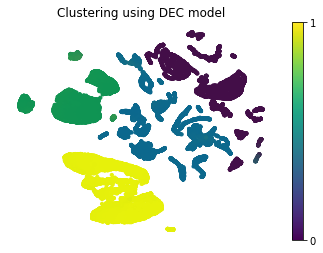

In [79]:
colors = []
cluster_colors = {0:np.array([70,0,70]),1:np.array([255,255,0]),3:np.array([0,153,85]),2:np.array([0,100,153])}
#cluster_colors = {0:np.array([255,0,0]),1:np.array([0,255,0]),2:np.array([0,0,255]),3:np.array([255,255,0])}
for n in list_of_floats:
    color = np.zeros([3])
    for i in range(len(n)):
        color +=  cluster_colors[i]*n[i]

    colors.append(color)
colors = np.asarray(colors)


y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))


vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(3)
#for i in range(len(vis_xx)):
plt.scatter(vis_xx, vis_yy, c=colors/255.0,  marker=".", s=40)
plt.colorbar(ticks=range(256))
plt.axis('off')
#plt.clim(-0.5, 9.5)
plt.title('Clustering using DEC model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()





In [31]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment as linear_assignment

#data = pd.read_csv('merge_final.csv')
#data.head()
#data_x = data.drop(['index'], axis=1)
#data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )
#y = data_x['LOS']


y_pred = pd.read_csv('kpred1.csv',header=None)
print(y_pred)
y_pred = y_pred.astype(int)
y = pd.read_csv('ytrue.csv', header=None)
#print(y)

y = y.astype(int)
y = pd.DataFrame(y).to_numpy()
y_pred=pd.DataFrame(y_pred).to_numpy()


def best_cluster_fit(y, y_pred):
    y = y.astype(np.int64)
    D = max(y_pred.max(), y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y[i]] += 1

    ind = linear_assignment(w.max() - w)
    best_fit = []
    for i in range(y_pred.size):
        for j in range(len(ind)):
            if ind[j][0] == y_pred[i]:
                best_fit.append(ind[j][1])
    return best_fit, ind, w


_, ind, w = best_cluster_fit(y, y_pred)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
print(acc)
print((_))
np.savetxt("correct.csv", _, delimiter=",")
#print(len(y))
#print(len(y_pred))

         0
0      0.0
1      7.0
2     14.0
3      0.0
4      5.0
...    ...
6441   0.0
6442  14.0
6443  14.0
6444   0.0
6445  11.0

[6446 rows x 1 columns]


FileNotFoundError: [Errno 2] No such file or directory: 'ytrue.csv'

In [1]:
#new_labels = [ permutation[label] for label in y_pred]   # permute the labels
#print("Accuracy score is", accuracy_score(y, new_labels))

In [ ]:
yw = [[2],[2],2,1,1,0,3,3]
yc = [3,3,3,2,2,0,1,1]
q = [0.1, 0.6, 0.1, 0.0]

x = np.zeros(len(yw))
for i in range(len(yw)):
    k = yw[i]
    j = yc[i]
    x[k] = j

f = np.zeros(4)
y = x[0:4]
for ii in range(4):

    print(int(y[ii]))
    z = int(y[ii])
    f[ii] = q[z]

In [125]:
def dbs_soft(freq,df_q):

    print('func',df_q)
    df_q['dec_soft'] = df_q[[0, 1 ,2, 3]].values.tolist()
   
    #n = []
    #for j in df_q.dec_soft:
        #norm = [float(i) for i in j]
        #n.append(norm)
    
    #df_q['dec_soft'] = n

#########
    list_of_float = []
    for item in freq:
        norm = [float(i) for i in item]
        list_of_float.append(norm)
    list_of_float
    

    df_qq = pd.DataFrame(list_of_float, columns=['ytrue'])
    prefix_cols = ['yt']
    dummy_cols = ['ytrue']
    df_qq = pd.get_dummies(df_qq, prefix=prefix_cols, columns=dummy_cols)
    df_qq['freq'] = df_qq[['yt_0.0','yt_1.0', 'yt_2.0', 'yt_3.0']].values.tolist()
    
    n = []
    for j in df_qq.freq:
        norm = [float(i) for i in j]
        n.append(norm)
    
    df_qq['freq'] = n
    
   #print('freq',df_qq)
   # print('dec',df_q)
    pos = [1,2,4,8]
    err = np.zeros((df_qq.freq).size)
    k = 0
    for j in range((df_qq.freq).size):
    
        i = 0
        if df_qq.freq[j][i] == 1.0 and df_qq.freq[j][i+1] == 0.0 and df_qq.freq[j][i+2] == 0.0 and df_qq.freq[j][i+3] == 0.0:
            err[k] = ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*1 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*2 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*4 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*8
       
        elif df_qq.freq[j][i] == 0.0 and df_qq.freq[j][i+1] == 1.0 and df_qq.freq[j][i+2] == 0.0 and df_qq.freq[j][i+3] == 0.0:
            err[k] = ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*4 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*1 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*2 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*8
        
        elif df_qq.freq[j][i] == 0.0 and df_qq.freq[j][i+1] == 0.0 and df_qq.freq[j][i+2] == 1.0 and df_qq.freq[j][i+3] == 0.0:
            err[k]= ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*8 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*4 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*1 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*2
        
        elif df_qq.freq[j][i] == 0.0 and df_qq.freq[j][i+1] == 0.0 and df_qq.freq[j][i+2] == 0.0 and df_qq.freq[j][i+3] == 1.0:
            err[k] = ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*8 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*4 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*2 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*1

        k = k+1

    return np.mean(err)


In [122]:
def dbs(freq,dec_soft):


    list_of_floats = []
    for item in dec_soft:
        norm = [float(i) for i in item]
        list_of_floats.append(norm)
    list_of_floats

    df_q = pd.DataFrame(list_of_floats, columns=['dec_pred'])
    prefix_cols = ['dec']
    dummy_cols = ['dec_pred']
    df_q = pd.get_dummies(df_q, prefix=prefix_cols, columns=dummy_cols)
    df_q['dec_soft'] = df_q[['dec_0.0','dec_1.0', 'dec_2.0', 'dec_3.0']].values.tolist()
    
    n = []
    for j in df_q.dec_soft:
        norm = [float(i) for i in j]
        n.append(norm)
    
    df_q['dec_soft'] = n
#########
    list_of_float = []
    for item in freq:
        norm = [float(i) for i in item]
        list_of_float.append(norm)
    list_of_float
    

    df_qq = pd.DataFrame(list_of_float, columns=['ytrue'])
    prefix_cols = ['yt']
    dummy_cols = ['ytrue']
    df_qq = pd.get_dummies(df_qq, prefix=prefix_cols, columns=dummy_cols)
    df_qq['freq'] = df_qq[['yt_0.0','yt_1.0', 'yt_2.0', 'yt_3.0']].values.tolist()
    
    n = []
    for j in df_qq.freq:
        norm = [float(i) for i in j]
        n.append(norm)
    
    df_qq['freq'] = n
    
   #print('freq',df_qq)
   # print('dec',df_q)
    pos = [1,2,4,8]
    err = np.zeros((df_qq.freq).size)
    k = 0
    for j in range((df_qq.freq).size):
    
        i = 0
        if df_qq.freq[j][i] == 1.0 and df_qq.freq[j][i+1] == 0.0 and df_qq.freq[j][i+2] == 0.0 and df_qq.freq[j][i+3] == 0.0:
            err[k] = ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*1 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*2 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*4 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*8
       
        elif df_qq.freq[j][i] == 0.0 and df_qq.freq[j][i+1] == 1.0 and df_qq.freq[j][i+2] == 0.0 and df_qq.freq[j][i+3] == 0.0:
            err[k] = ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*4 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*1 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*2 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*8
        
        elif df_qq.freq[j][i] == 0.0 and df_qq.freq[j][i+1] == 0.0 and df_qq.freq[j][i+2] == 1.0 and df_qq.freq[j][i+3] == 0.0:
            err[k]= ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*8 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*4 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*1 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*2
        
        elif df_qq.freq[j][i] == 0.0 and df_qq.freq[j][i+1] == 0.0 and df_qq.freq[j][i+2] == 0.0 and df_qq.freq[j][i+3] == 1.0:
            err[k] = ((df_qq.freq[j][i] - df_q.dec_soft[j][i])**2)*8 + ((df_qq.freq[j][i+1] - df_q.dec_soft[j][i+1])**2)*4 + \
                    ((df_qq.freq[j][i+2] - df_q.dec_soft[j][i+2])**2)*2 + ((df_qq.freq[j][i+3] - df_q.dec_soft[j][i+3])**2)*1

        k = k+1

    return np.mean(err)


In [130]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.utils.linear_assignment_ import linear_assignment
from csv import reader


data = pd.read_csv('merge_final.csv')
data.head()
data_x = data.drop(['index'], axis=1)
data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )

ytrue = data_x['LOS']
data_x = data.drop(['LOS'], axis=1)
ytrue = ytrue.astype(int)
#print(ytrue.dtype)

#ytrue.to_csv('ytrue_hard.csv',index=False)
#data_x = data_x.drop(['ICD9_CODE'], axis=1)


numeric_columns = data_x.columns.values.tolist()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()
data_x.isnull().sum()
data_x.fillna(0, inplace=True)
data_x.isnull().sum()
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    #hidden = self.autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
    
    
    return autoencoder_model, encoder_model
	
data_x.dtypes
x = data_x.values
x.shape

n_clusters = 4 # 3 - 0.291, 4 - 0.280, 5 - 0.228, 6 - 0.227, 10 - 0.192
n_epochs   = 1
batch_size = 128

kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.01, momentum=0.9)

pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = './results'

dims
autoencoder, encoder = autoencoder(dims, init=init)

'''
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')
 '''

autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')


autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
    

'''
#plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
'''

np.savetxt("encoder_predict.csv", encoder.predict(x), delimiter=",")

class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

 

model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
#model =Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
#model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

'''
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')
'''

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

y_pred_last = np.copy(y_pred)

model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T
	
loss = 0
index = 0
maxiter = 1 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

tol = 0.001 # tolerance threshold to stop training
'''
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
'''
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)



def best_cluster_fit(y, y_pred):
    y = y.astype(np.int64)
    D = max(y_pred.max(), y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y[i]] += 1

    ind = linear_assignment(w.max() - w)
    best_fit = []
    for i in range(y_pred.size):
        for j in range(len(ind)):
            if ind[j][0] == y_pred[i]:
                best_fit.append(ind[j][1])
    return best_fit, ind, w

acc = np.zeros(10)
er = np.zeros(10)
er_soft = np.zeros(10)
los = np.zeros(int(maxiter))
a1=0
aa1=0
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)#(kl)

        # check stop criterion
        #delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        #y_pred_last = np.copy(y_pred)
        #if ite > 0 and delta_label < tol:
            #print('delta_label ', delta_label, '< tol ', tol)
            #print('Reached tolerance threshold. Stopping training.')
            #break
            
        y = pd.DataFrame(ytrue).to_numpy()
        y_pred=pd.DataFrame(y_pred).to_numpy()



        _, ind, w = best_cluster_fit(y, y_pred)
        acc[a1] = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
        #print(acc)
        ypredictt = pd.DataFrame(_).to_numpy()
        
        ypredict = pd.DataFrame(_)
        np.savetxt("ypredict.csv", ypredict, delimiter=",")
        np.savetxt("ytruee.csv", ytrue, delimiter=",")
        np.savetxt("q.csv", q, delimiter=",")
        
            

        v = np.zeros(len(y_pred))
        for i in range(len(y_pred)):
            k = y_pred[i]
            j = ypredictt[i]
            v[k] = j
    
        q_soft = pd.read_csv('q.csv',header=None,usecols=[0,1,2,3])
        print('bef',q_soft)
        #f = np.zeros(4)
        #q_soft_correct = []
        y = v[0:4]
        print(y)

        q_soft = q_soft[[int(y[0]),int(y[1]),int(y[2]),int(y[3])]]
        q_soft.columns = [0, 1, 2, 3]

        print('af',q_soft)
        with open('ypredict.csv', 'r') as read_obj:

            csv_reader = reader(read_obj)

            ypredicted = list(csv_reader)

            
        with open('ytruee.csv', 'r') as read_obj:

            csv_reader = reader(read_obj)

            ytrueee = list(csv_reader)
            
        er[a1] = dbs(ytrueee, ypredicted)
    
        er_soft[a1] = dbs_soft(ytrueee, q_soft)
        


        a1=a1+1
        
    idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
    #if ite % update_interval == 0:
    los[aa1] = loss
    aa1 = aa1+1


# Eval.
q = model.predict(x, verbose=0)
#np.savetxt("q_dec_data1.csv", q, delimiter=",")
p = target_distribution(q)  # update the auxiliary target distribution p


# evaluate the clustering performance
y_pred = q.argmax(1)

data_all = data_x.copy()

data_all['cluster'] = y_pred

data_all.head()

data_all['cluster'].value_counts()

'''
miter=[]
for i in range(0, 1000):
    miter.append(i)

#plt.ylim([acc[0]-0.01, acc[21]+ 0.01])
plt.plot(miter, acc)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

#plt.ylim([er[0]-0.01, er[21]+ 0.01])
plt.plot(miter, er)
plt.xlabel('Epochs')
plt.ylabel('DBS')
plt.show()


#cluster_colors = {0:np.array([255,0,0]),1:np.array([0,255,0]),2:np.array([0,0,255]),3:np.array([255,255,0])}
pca = PCA(n_components=2)
x_pca = pca.fit_transform(encoder.predict(x))

x_embedded = TSNE(n_components=2).fit_transform(encoder.predict(x))

y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))
x_embedded.shape

visx = x_pca[:, 0]
visy = x_pca[:, 1]
plot1 = plt.figure(1)
plt.scatter(visx, visy, c=y_pred)
plt.colorbar(ticks=range(256))
plt.title('Clustering using DEC model')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plot1 = plt.figure(2)
plt.scatter(vis_x, vis_y, c=y_pred)
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
plt.title('Clustering using DEC model')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()

vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(3)
plt.scatter(vis_xx, vis_yy, c=y_pred)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using DEC model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(4)
plt.scatter(vis_xx, vis_yy, c=ytrue)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using DEC model T')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


#y_pred_kmeans.shape
#x_embedded = TSNE(n_components=2).fit_transform(encoder.predict(x))

#y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))
#vis_x = x_embedded[:, 0]
#vis_y = x_embedded[:, 1]

#vis_xx = y_embedded[:, 0]
#vis_yy = y_embedded[:, 1]
plot1 = plt.figure(5)
plt.scatter(visx, visy, c=y_pred_kmeans)
plt.colorbar(ticks=range(256))
plt.title('Clustering using K-means model')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

plot1 = plt.figure(6)
plt.scatter(vis_x, vis_y, c=y_pred_kmeans)
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
plt.title('Clustering using K-means model')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()

plot1 = plt.figure(7)
plt.scatter(vis_xx, vis_yy, c=y_pred_kmeans)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using Kmeans model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

 #For n_clusters = 3, Kmeans silhouette score is 0.3723536590701517)
# For n_clusters = 4, Kmeans silhouette score is 0.3215079773343314)
# For n_clusters = 10, Kmeans silhouette score is 0.34194939183619716)
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (encoder.predict(x), y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

# For n_clusters = 3, Deep clustering silhouette score is 0.29138845064227953)
# For n_clusters = 4, Deep clustering silhouette score is 0.28032271072644543)
# For n_clusters = 10, Deep clustering silhouette score is 0.19216022223500343)
score = silhouette_score (encoder.predict(x), y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(encoder.predict(x))
    # centers = clusterer.cluster_centers_
    score = silhouette_score (encoder.predict(x), preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))



y_pred = y_pred.astype(int)
y_pred_kmeans = y_pred_kmeans.astype(int)

#score = metrics.accuracy_score(y,y_pred_kmeans)
#print('Accuracykm:{0:f} '.format(score))

#score = metrics.accuracy_score(y,y_pred)
#print('Accuracydec:{0:f}'.format(score))

#np.savetxt("decpred_data1.csv", y_pred, delimiter=",")
#np.savetxt("kpred_data1.csv", y_pred_kmeans, delimiter=",")
#np.savetxt("ytrue_data1.csv", ytrue, delimiter=",")

'''



Epoch 1/1
45691/45691 [==============================] - 16s 342us/step - loss: 0.0477


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


bef               0         1         2         3
0      0.250060  0.249966  0.249994  0.249980
1      0.250045  0.249899  0.250024  0.250032
2      0.250023  0.249854  0.250002  0.250121
3      0.250070  0.249999  0.250044  0.249887
4      0.250063  0.249966  0.249991  0.249979
...         ...       ...       ...       ...
45686  0.250018  0.249848  0.249978  0.250156
45687  0.250052  0.249988  0.250052  0.249908
45688  0.250022  0.249938  0.249995  0.250045
45689  0.250034  0.250029  0.249990  0.249947
45690  0.250078  0.249982  0.250012  0.249927

[45691 rows x 4 columns]
[1. 0. 3. 2.]
af               0         1         2         3
0      0.249966  0.250060  0.249980  0.249994
1      0.249899  0.250045  0.250032  0.250024
2      0.249854  0.250023  0.250121  0.250002
3      0.249999  0.250070  0.249887  0.250044
4      0.249966  0.250063  0.249979  0.249991
...         ...       ...       ...       ...
45686  0.249848  0.250018  0.250156  0.249978
45687  0.249988  0.250052  0.2499

'\nmiter=[]\nfor i in range(0, 1000):\n    miter.append(i)\n\n#plt.ylim([acc[0]-0.01, acc[21]+ 0.01])\nplt.plot(miter, acc)\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Training Loss\')\nplt.show()\n\n#plt.ylim([er[0]-0.01, er[21]+ 0.01])\nplt.plot(miter, er)\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'DBS\')\nplt.show()\n\n\n#cluster_colors = {0:np.array([255,0,0]),1:np.array([0,255,0]),2:np.array([0,0,255]),3:np.array([255,255,0])}\npca = PCA(n_components=2)\nx_pca = pca.fit_transform(encoder.predict(x))\n\nx_embedded = TSNE(n_components=2).fit_transform(encoder.predict(x))\n\ny_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))\nx_embedded.shape\n\nvisx = x_pca[:, 0]\nvisy = x_pca[:, 1]\nplot1 = plt.figure(1)\nplt.scatter(visx, visy, c=y_pred)\nplt.colorbar(ticks=range(256))\nplt.title(\'Clustering using DEC model\')\nplt.xlabel(\'PCA1\')\nplt.ylabel(\'PCA2\')\nplt.show()\n\nvis_x = x_embedded[:, 0]\nvis_y = x_embedded[:, 1]\nplot1 = plt.figure(2)\nplt.scatter(vis_x, vis_y, c

In [128]:
er_soft

array([1.4376379, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ])

In [1]:
#np.savetxt("encoder_pred.csv", encoder.predict(x), delimiter=",")
miter=[]
for i in range(0, 1000):
    miter.append(i)
print(miter)   
plt.ylim([acc[0]-0.018, acc[19]+ 0.018])
plt.plot(miter, acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.ylim([er[0]-0.02, er[19]+ 0.02])
plt.plot(miter, er)
plt.xlabel('Epochs')
plt.ylabel('DBS')
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

NameError: name 'plt' is not defined

In [44]:
np.savetxt("decpred_data12.csv", y_pred, delimiter=",")
np.savetxt("kpred_data12.csv", y_pred_kmeans, delimiter=",")
np.savetxt("encoder_pred.csv", encoder.predict(x), delimiter=",")

In [30]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.utils.linear_assignment_ import linear_assignment

#data = pd.read_csv('merge_final.csv')
#data.head()
#data_x = data.drop(['index'], axis=1)
#data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )
#y = data_x['LOS']


y_pred = pd.read_csv('kpred_data12.csv', header=None)
y_pred = y_pred.astype(int)
y = pd.read_csv('ytrue.csv', header=None)
y = y.astype(int)
y = pd.DataFrame(y).to_numpy()
y_pred=pd.DataFrame(y_pred).to_numpy()


def best_cluster_fit(y, y_pred):
    y = y.astype(np.int64)
    D = max(y_pred.max(), y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y[i]] += 1

    ind = linear_assignment(w.max() - w)
    best_fit = []
    for i in range(y_pred.size):
        for j in range(len(ind)):
            if ind[j][0] == y_pred[i]:
                best_fit.append(ind[j][1])
    return best_fit, ind, w


_, ind, w = best_cluster_fit(y, y_pred)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
print(acc)

np.savetxt("correct.csv", _, delimiter=",")


FileNotFoundError: [Errno 2] No such file or directory: 'ytrue.csv'

In [28]:

import pandas as pd
y_pred = pd.read_csv('idecpred_data2.csv', header=None)
y_pred_correct = pd.read_csv('correct.csv', header=None)

y_pred = y_pred.values.tolist()
y_pred_correct = y_pred_correct.values.tolist()
print(y_pred[1:5])
print(y_pred_correct[1:5])
y = []

#for i in range(20):
    if y_pred[i]== y_pred_correct[i]:
        h[k] = i 
    y_pred[i]= y_pred_correct[i]
    #print(y_pred)
    y.append(y_pred[k])

  


[[13.0], [15.0], [14.0], [8.0]]
[[2.0], [6.0], [12.0], [5.0]]


In [49]:
yw = [2,2,2,1,1,0,3,3]
yc = [3,3,3,2,2,0,1,1]
q = [0.1, 0.6, 0.1, 0.0]

x = np.zeros(len(yw))
for i in range(len(yw)):
    k = yw[i]
    j = yc[i]
    x[k] = j

f = np.zeros(4)
y = x[0:4]
for ii in range(4):

    print(int(y[ii]))
    z = int(y[ii])
    f[ii] = q[z]

print(f)



0
2
3
1
[0.1 0.1 0.  0.6]


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Epoch 1/1
45691/45691 [==============================] - 9s 196us/step - loss: 0.0367
[0.02304865, 0.060700074, 0.016978642]


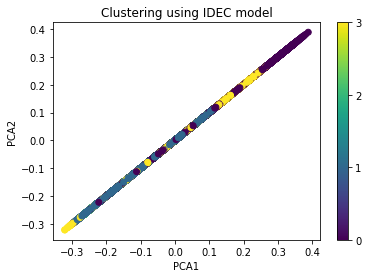

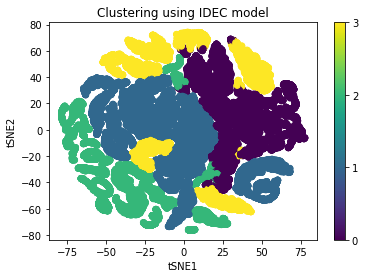

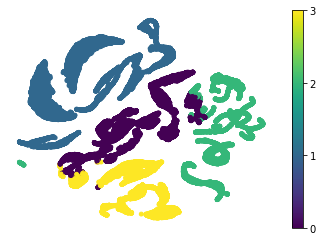

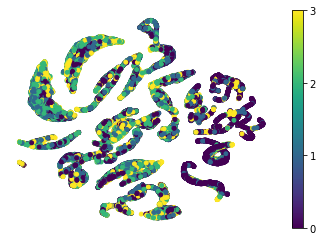

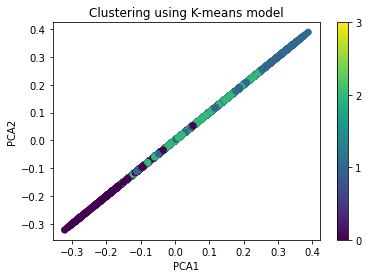

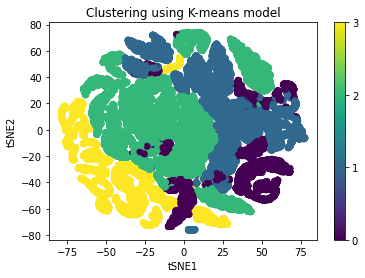

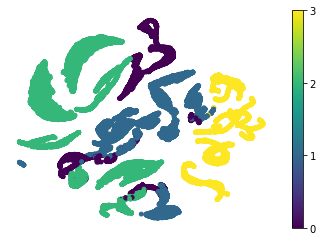

For n_clusters = 4, Kmeans silhouette score is 0.33824822306632996)
For n_clusters = 4, Deep clustering silhouette score is 0.7253039479255676)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 2, Kmeans silhouette score is 0.678095817565918)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 3, Kmeans silhouette score is 0.6817417144775391)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 4, Kmeans silhouette score is 0.7841811776161194)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 5, Kmeans silhouette score is 0.744274377822876)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 6, Kmeans silhouette score is 0.6510615348815918)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 7, Kmeans silhouette score is 0.6199781894683838)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 8, Kmeans silhouette score is 0.6093424558639526)


C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


For n_clusters = 9, Kmeans silhouette score is 0.5712156295776367)


In [10]:

from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

data = pd.read_csv('merge_final.csv')
data.head()
data_x = data.drop(['index'], axis=1)

data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )

ytrue = data_x['LOS']
ytrue= ytrue.astype(int)
data_x = data.drop(['LOS'], axis=1)
#ytrue.to_csv('iytrue.csv',index=False)
#data_x = data_x.drop(['ICD9_CODE'], axis=1)


numeric_columns = data_x.columns.values.tolist()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()
data_x.isnull().sum()
data_x.fillna(0, inplace=True)
data_x.isnull().sum()


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.

    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10].
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function

    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1

    input_data = Input(shape=(dims[0],), name='input')
    x = input_data

    # internal layers of encoder
    for i in range(n_stacks - 1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks - 1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)

    decoded = x

    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model = Model(inputs=input_data, outputs=encoded, name='encoder')

    return autoencoder_model, encoder_model


data_x.dtypes
x = data_x.values
x.shape

n_clusters = 4  # 3 - 0.291, 4 - 0.280, 5 - 0.228, 6 - 0.227, 10 - 0.192
n_epochs = 1
batch_size = 128

kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')
pretrain_optimizer = SGD(lr=0.1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size


dims
autoencoder, encoder = autoencoder(dims, init=init)
'''
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')
 '''

autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)



class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim),
                                        initializer='glorot_uniform')

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        '''
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)

        inputs: the variable containing data, shape=(n_samples, n_features)

        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))  # Make sure all of the values of each sample sum up to 1.

        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)


'''
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 
'''
#model.compile(optimizer=SGD(0.01, 0.9), loss='kld')


kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

y_pred_last = np.copy(y_pred)

model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])


def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


loss = 0
index = 0
maxiter = 600 # 8000
update_interval = 100  # 140
index_array = np.arange(x.shape[0])

tol = 0.001  # tolerance threshold to stop training
'''
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx],x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
'''
ep=10
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q,_ = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break

        
    idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

print(loss)


# Eval.
q, _ = model.predict(x, verbose=0)
#np.savetxt("q_idec_data1.csv", q, delimiter=",")
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

data_all = data_x.copy()

data_all['cluster'] = y_pred

data_all.head()

data_all['cluster'].value_counts()

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(encoder.predict(x))

x_embedded = TSNE(n_components=2).fit_transform(encoder.predict(x))

y_embedded = umap.UMAP(n_components=2).fit_transform(encoder.predict(x))
x_embedded.shape

vis = x_pca[:, 0]
vis = x_pca[:, 1]
plot1 = plt.figure(1)
plt.scatter(vis, vis, c=y_pred)
plt.colorbar(ticks=range(256))
plt.title('Clustering using IDEC model')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plot1 = plt.figure(2)
plt.scatter(vis_x, vis_y, c=y_pred)
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
plt.title('Clustering using IDEC model')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()

vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(3)
plt.scatter(vis_xx, vis_yy, c=y_pred, marker=".", s=60)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using IDEC model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(4)
plt.scatter(vis_xx, vis_yy, c=ytrue, marker=".", s=60)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using IDEC model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

plot1 = plt.figure(5)
plt.scatter(vis, vis, c=y_pred_kmeans)
plt.colorbar(ticks=range(256))
plt.title('Clustering using K-means model')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

plot1 = plt.figure(6)
plt.scatter(vis_x, vis_y, c=y_pred_kmeans)
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
plt.title('Clustering using K-means model')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()

plot1 = plt.figure(7)
plt.scatter(vis_xx, vis_yy, c=y_pred_kmeans, marker=".", s=60)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using Kmeans model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# For n_clusters = 3, Kmeans silhouette score is 0.3723536590701517)
# For n_clusters = 4, Kmeans silhouette score is 0.3215079773343314)
# For n_clusters = 10, Kmeans silhouette score is 0.34194939183619716)
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score(encoder.predict(x), y_pred_kmeans, metric='euclidean')
print("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

# For n_clusters = 3, Deep clustering silhouette score is 0.29138845064227953)
# For n_clusters = 4, Deep clustering silhouette score is 0.28032271072644543)
# For n_clusters = 10, Deep clustering silhouette score is 0.19216022223500343)
score = silhouette_score(encoder.predict(x), y_pred, metric='euclidean')
print("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

for num_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(encoder.predict(x))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(encoder.predict(x), preds, metric='euclidean')
    print("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))


#np.savetxt("idecpred_data1.csv", y_pred, delimiter=",")
#np.savetxt("ikpred_data1.csv", y_pred_kmeans, delimiter=",")


In [29]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.utils.linear_assignment_ import linear_assignment

#data = pd.read_csv('merge_final.csv')
#data.head()
#data_x = data.drop(['index'], axis=1)
#data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )
#y = data_x['LOS']


y_pred = pd.read_csv('idecpred_data1.csv', header=None)
y_pred = y_pred.astype(int)
y = pd.read_csv('ytrue.csv', header=None)
y = y.astype(int)
y = pd.DataFrame(y).to_numpy()
y_pred=pd.DataFrame(y_pred).to_numpy()

      
def best_cluster_fit(y, y_pred):
    y = y.astype(np.int64)
    D = max(y_pred.max(), y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y[i]] += 1

    ind = linear_assignment(w.max() - w)
    best_fit = []
    for i in range(y_pred.size):
        for j in range(len(ind)):
            if ind[j][0] == y_pred[i]:
                best_fit.append(ind[j][1])
    return best_fit, ind, w


_, ind, w = best_cluster_fit(y, y_pred)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
print(acc)
print(_)
print(y_pred)
np.savetxt("correct.csv", _ , delimiter=",")

FileNotFoundError: [Errno 2] No such file or directory: 'ytrue.csv'

In [38]:
np.savetxt("encoder_pred.csv", encoder.predict(x), delimiter=",")

In [49]:
np.savetxt("idecpred_data12.csv", y_pred, delimiter=",")
np.savetxt("ikpred_data12.csv", y_pred_kmeans, delimiter=",")

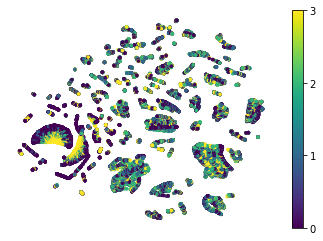

In [55]:
vis_xx = y_embedded[:, 0]
vis_yy = y_embedded[:, 1]
plot1 = plt.figure(4)
plt.scatter(vis_xx, vis_yy, c=ytrue, marker=".", s=25)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using IDEC model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

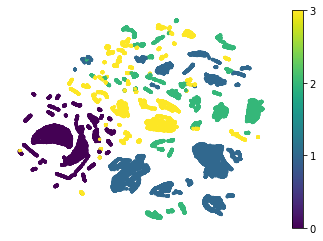

In [56]:
plot1 = plt.figure(7)
plt.scatter(vis_xx, vis_yy, c=y_pred_kmeans, marker=".", s=25)
plt.axis('off')
plt.colorbar(ticks=range(256))
#plt.clim(-0.5, 9.5)
#plt.title('Clustering using Kmeans model')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [93]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.utils.linear_assignment_ import linear_assignment
from csv import reader


data = pd.read_csv('merge_final.csv')
data.head()
data_x = data.drop(['index'], axis=1)
data_x['LOS'] = data_x['LOS'].apply(lambda x: '0' if x >= 0 and x<=4  else ('1' if x >= 5 and x<=7  else('2' if x >= 8 and x<=14 else '3')) )

ytrue = data_x['LOS']
data_x = data_x.drop(['LOS'], axis=1)
ytrue = ytrue.astype(int)
#print(ytrue.dtype)




numeric_columns = data_x.columns.values.tolist()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()
data_x.isnull().sum()
data_x.fillna(0, inplace=True)
data_x.isnull().sum()
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    #hidden = self.autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
    
    
    return autoencoder_model, encoder_model
	
data_x.dtypes
x = data_x.values
x.shape

n_clusters = 4 # 3 - 0.291, 4 - 0.280, 5 - 0.228, 6 - 0.227, 10 - 0.192
n_epochs   = 100
batch_size = 128

kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.01, momentum=0.9)

pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = './results'

dims
autoencoder, encoder = autoencoder(dims, init=init)

'''
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')
 '''

autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')

def best_cluster_fit(y, y_pred):
    y = y.astype(np.int64)
    D = max(y_pred.max(), y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y[i]] += 1

    ind = linear_assignment(w.max() - w)
    best_fit = []
    for i in range(y_pred.size):
        for j in range(len(ind)):
            if ind[j][0] == y_pred[i]:
                best_fit.append(ind[j][1])
    return best_fit, ind, w

ac = np.zeros(10)
err = np.zeros(10)
loss = np.zeros(100)
a2 = 0

for i in range(pretrain_epochs):
  loss = autoencoder.train_on_batch(x, x)
  if i % 10  == 0:
    kmeans = KMeans(n_clusters=n_clusters)
    y_pred = kmeans.fit_predict(encoder.predict(x))
    y = pd.DataFrame(ytrue).to_numpy()
    y_pred =pd.DataFrame(y_pred).to_numpy()


    _, ind, w = best_cluster_fit(y, y_pred)
    ac[a2] = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    #print(acc)
        
    ypredict = pd.DataFrame(_)
    np.savetxt("ypredictauto.csv", ypredict, delimiter=",")
    np.savetxt("ytrueauto.csv", ytrue, delimiter=",")

    with open('ypredictauto.csv', 'r') as read_obj:

        csv_reader = reader(read_obj)

        ypredicteda = list(csv_reader)
    with open('ytrueauto.csv', 'r') as read_obj:

        csv_reader = reader(read_obj)

        ytruea = list(csv_reader)
            
    err[a2] = dbs(ytruea, ypredicteda)
    #print(er)
    a2=a2+1

    

'''
#plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
'''

np.savetxt("encoder_predict.csv", encoder.predict(x), delimiter=",")
np.savetxt("his_loss.csv", loss, delimiter=",")
np.savetxt("dbs.csv", err, delimiter=",")
np.savetxt("accuracy.csv", ac, delimiter=",")
encoder.save("encoderModel.hdf5")

C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
C:\Users\gavry\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 an

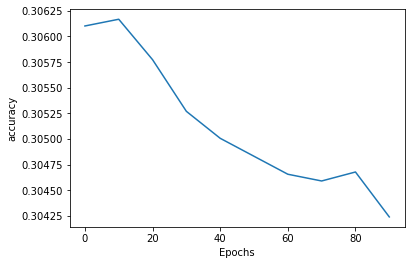

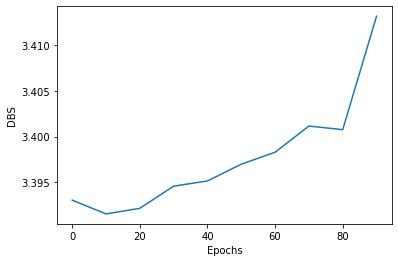

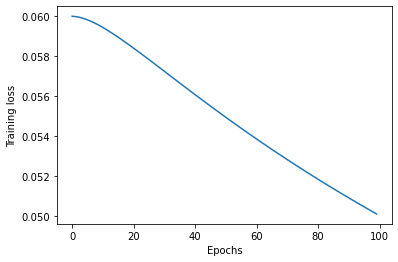

In [94]:
miter=[]
for i in range(0, 100):
    miter.append(i)

miterate=[]
for i in range(0, 100, 10):
    miterate.append(i)

plt.plot(miterate, ac)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

#plt.ylim([er[0]-0.01, er[21]+ 0.01])
plt.plot(miterate, err)
plt.xlabel('Epochs')
plt.ylabel('DBS')
plt.show()

plt.plot(miter, loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

In [7]:
import numpy as np
miter=np.zeros(500)
k = 0
for i in range(1, 501):
    miter[k]=int(i)
    k = k+1
print(miter)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196.
 197. 